In [73]:
import custom_utils
import matplotlib.pyplot as plt
import tensorrt as trt
import pycuda.autoinit
import pycuda.driver as cuda
import numpy as np
import cv2
import tqdm.notebook as tqdm

class BaseEngine(object):
    def __init__(self, engine_path, imgsz=(640,640)):
        self.imgsz = imgsz
        self.mean = None
        self.std = None
        self.class_names = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]
        logger = trt.Logger(trt.Logger.WARNING)
        trt.init_libnvinfer_plugins(logger,'')
        runtime = trt.Runtime(logger)
        with open(engine_path, "rb") as f:
            serialized_engine = f.read()
        engine = runtime.deserialize_cuda_engine(serialized_engine)
        self.context = engine.create_execution_context()
        self.inputs, self.outputs, self.bindings = [], [], []
        self.stream = cuda.Stream()
        for binding in engine:
            size = trt.volume(engine.get_binding_shape(binding))
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            host_mem = cuda.pagelocked_empty(size, dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)
            self.bindings.append(int(device_mem))
            if engine.binding_is_input(binding):
                self.inputs.append({'host': host_mem, 'device': device_mem})
            else:
                self.outputs.append({'host': host_mem, 'device': device_mem})
                
    def infer(self, img):
        self.inputs[0]['host'] = np.ravel(img)
        # transfer data to the gpu
        for inp in self.inputs:
            cuda.memcpy_htod_async(inp['device'], inp['host'], self.stream)
        # run inference
        self.context.execute_async_v2(
            bindings=self.bindings,
            stream_handle=self.stream.handle)
        # fetch outputs from gpu
        for out in self.outputs:
            cuda.memcpy_dtoh_async(out['host'], out['device'], self.stream)
        # synchronize stream
        self.stream.synchronize()

        data = [out['host'] for out in self.outputs]
        return data

    def inference(self, img_path, conf=0.25):
        origin_img = cv2.imread(img_path)
        origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
        img, ratio = preproc(origin_img, self.imgsz, self.mean, self.std)
        num, final_boxes, final_scores, final_cls_inds = self.infer(img)
        final_boxes = np.reshape(final_boxes, (-1, 4))
        num = num[0]
        if num >0:
            final_boxes, final_scores, final_cls_inds = final_boxes[:num]/ratio, final_scores[:num], final_cls_inds[:num]
            origin_img = vis(origin_img, final_boxes, final_scores, final_cls_inds,
                             conf=conf, class_names=self.class_names)
        origin_img = cv2.cvtColor(origin_img, cv2.COLOR_RGB2BGR)                      
        return origin_img

    def get_fps(self):
        # warmup
        import time
        img = np.ones((1,3,self.imgsz[0], self.imgsz[1]))
        img = np.ascontiguousarray(img, dtype=np.float32)
        for _ in range(20):
            _ = self.infer(img)
        t1 = time.perf_counter()
        _ = self.infer(img)
        print(1/(time.perf_counter() - t1), 'FPS')

def preproc(image, input_size, swap=(2, 0, 1)):
    if len(image.shape) == 3:
        padded_img = np.ones((input_size[0], input_size[1], 3)) * 114.0
    else:
        padded_img = np.ones(input_size) * 114.0
    img = np.array(image)
    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.float32)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    padded_img = padded_img[:, :, ::-1]
    padded_img /= 255.0
    padded_img = padded_img.transpose(swap)
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)
    return padded_img, r

def vis(img, boxes, scores, cls_ids, conf=0.5, class_names=None):
    for i in range(len(boxes)):
        box = boxes[i]
        cls_id = int(cls_ids[i])
        score = scores[i]
        if score < conf:
            continue
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = int(box[2])
        y1 = int(box[3])

        color = [255, 0, 0]
        text = '{:.1f}%'.format(score * 100)
        txt_color = (0, 0, 0)
        font = cv2.FONT_HERSHEY_SIMPLEX

        txt_size = cv2.getTextSize(text, font, 0.4, 1)[0]
        cv2.rectangle(img, (x0, y0), (x1, y1), color, 2)

        txt_bk_color = [255, 0, 0]
        cv2.rectangle(
            img,
            (x0, y0 + 1),
            (x0 + txt_size[0] + 1, y0 + int(1.5 * txt_size[1])),
            txt_bk_color,
            -1
        )
        cv2.putText(img, text, (x0, y0 + txt_size[1]), font, 0.4, txt_color, thickness=1)

    return img

In [47]:
pred = BaseEngine(engine_path='yolov7_single.trt')
origin_img = pred.inference('yolov7/inference/images/horses.jpg')

In [33]:
%matplotlib inline

In [4]:
#static camera properties
touchdown_target_lat_lon = [1.3541354199301814, 103.97961848373048]

data_indexes = [1,2]
data_sources = []
t = 1
r = 1
w = 1

for data_index in data_indexes:
    data_sources.append([f'dataset\\t{t}\\r{r}\\w{w}\\{data_index}\\data.pkl', f'dataset\\t{t}\\r{r}\\w{w}\\{data_index}\\video.avi'])
    
acd = custom_utils.aircraft_camera_data(data_sources = data_sources, touchdown_target_lat_lon = touchdown_target_lat_lon, model_sources = ["trained_mlp\\wsss_mono_view_1.pt", "trained_mlp\\wsss_mono_view_2.pt", "trained_mlp\\wsss_stereo.pt"])

acd.initiate_yolov7()
acd.initiate_mlp_dual()

Adding autoShape... 


In [ ]:
img = acd.get_frame_from_video(1, 3502)

In [79]:
for i in tqdm.trange(0, 1000):
    #img = acd.get_frame_from_video(1, 3502)
    im0 = preproc(img, [640,640], swap=(2, 0, 1))
    p = pred.infer(im0[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [38]:
# TensorRT FPS
pred.get_fps()

214.50481563301406 FPS


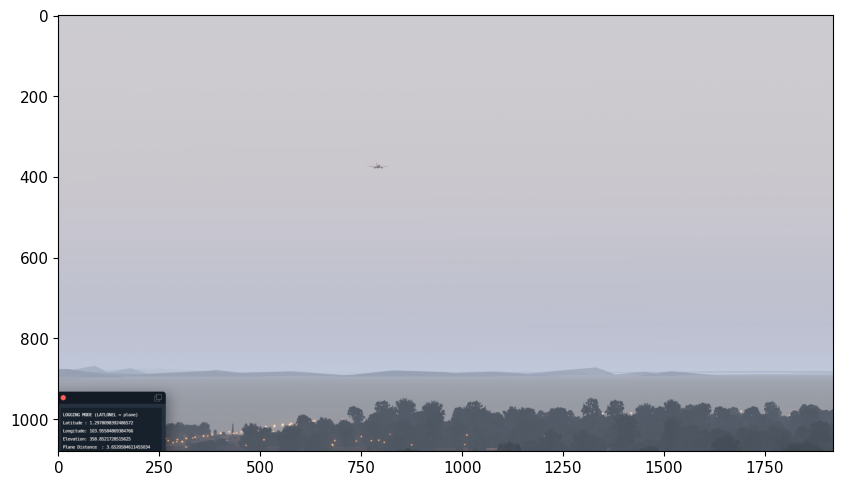

In [59]:
plt.figure(figsize=(10,10))
plt.imshow(img)

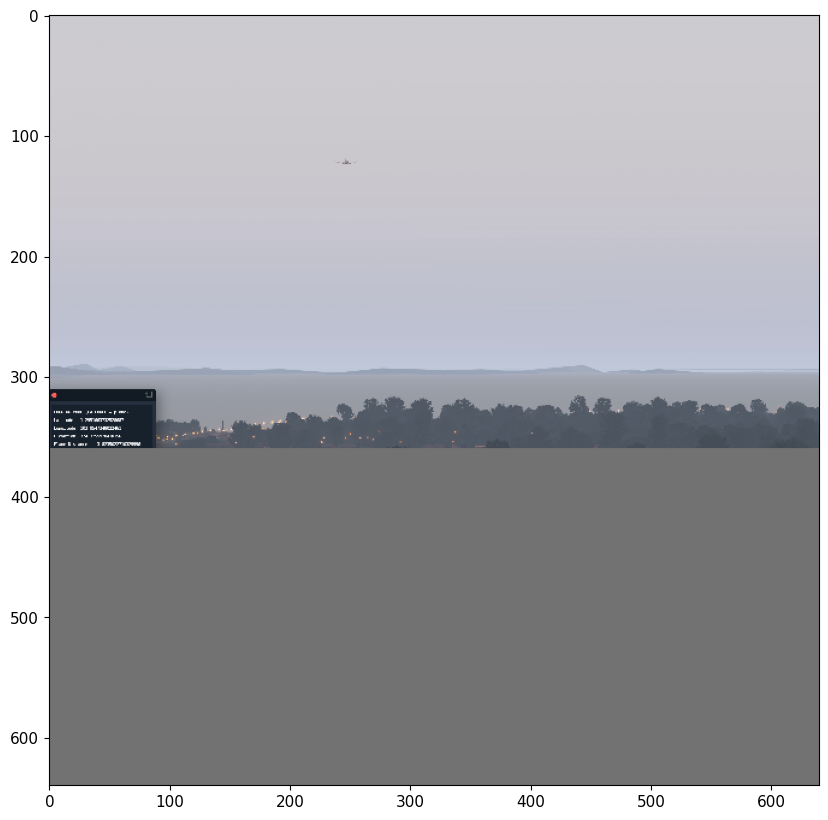

In [82]:
plt.figure(figsize=(10,10))
plt.imshow(im0[0].transpose(1,2,0)[:, :, ::-1])

In [153]:
im1 = np.stack((im0[0], im0[0])).shape

In [145]:
img = np.ascontiguousarray(img)

In [146]:
result_img = vis(img, p[1].reshape(-1, 4) * 3, p[2], p[3], conf=0.5, class_names=None)

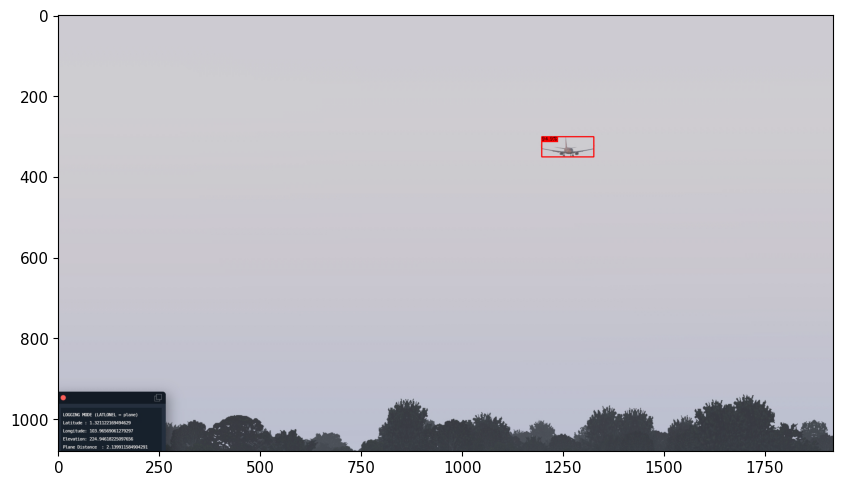

In [147]:
plt.figure(figsize=(10,10))
plt.imshow(result_img)